In [1]:
1*2

2

In [2]:
import importlib
def rl():
    importlib.reload(Di)

In [3]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |
|  4 |  0% |  0% |
|  5 |  0% |  0% |
|  6 |  0% |  0% |
|  7 |  0% |  0% |


In [4]:
import dask.dataframe as dd
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [5]:
import torch
import gpytorch

import pyarrow as pa
import pyarrow.parquet as pq

from scipy.stats import pearsonr
from scipy.special import binom as binom
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

import Di

In [6]:
geno_file_list = []
for path, currentDirectory, files in os.walk("96ghpptzvf-4/SData2/"):
    for file in files:
        if file.endswith("geno.txt"):
            geno_file_list.append(file)

geno_file_list = list(set(geno_file_list))

env_list = [file.split('_')[0] for file in geno_file_list]

env_list = sorted(env_list)

In [7]:
env = env_list[5]
print(env)

NaCl


In [8]:
df = pd.read_csv("96ghpptzvf-4/SData2/"+ env + "_geno.txt", sep='\t', nrows=5, engine='python')

In [9]:
ids = list(df.columns[3:])

In [10]:
env + '_matsui_geno_t.pt'

'NaCl_matsui_geno_t.pt'

In [11]:
geno_t = torch.load(env + '_matsui_geno_t.pt')

In [12]:
geno_t

tensor([[1., 2., 1.,  ..., 0., 0., 0.],
        [1., 2., 1.,  ..., 0., 0., 0.],
        [1., 2., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 2., 2.,  ..., 1., 1., 1.],
        [1., 2., 2.,  ..., 1., 1., 1.],
        [1., 2., 2.,  ..., 1., 1., 1.]], device='cuda:0', dtype=torch.float64)

In [13]:
geno_t = torch.transpose(geno_t, 0, 1)
N, L = geno_t.shape

In [14]:
pheno = pd.read_csv("96ghpptzvf-4/SData6/" + env + "_pheno.txt", sep='\t', engine="python")

In [15]:
pheno = pheno.set_index('geno')

In [16]:
pheno = pheno.loc[ids]

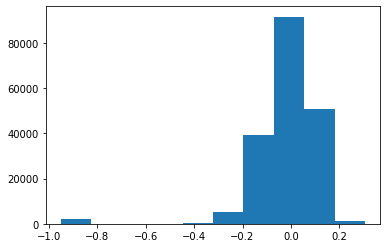

In [17]:
plt.hist(pheno.pheno)
plt.show()

### Set up

In [18]:
n_devices = torch.cuda.device_count()
print('Planning to run on {} GPUs.'.format(n_devices))

Planning to run on 8 GPUs.


In [19]:
output_device = torch.device('cuda:0')

### Data

In [65]:
inds_sub = np.where(np.array(pheno.pheno < -0.6) == False)[0]

In [66]:
np.random.seed(100)

In [67]:
sub = np.random.choice(inds_sub, 10000)

sub_t = np.random.choice(list(set(inds_sub).difference(sub)), 5)

In [68]:
train_x = geno_t[sub]
train_y = torch.tensor(np.array(pheno.pheno[sub]), dtype=torch.float32)

test_x = geno_t[sub_t]
test_y = torch.tensor(np.array(pheno.pheno[sub_t]), dtype=torch.float32)

In [69]:
train_x, train_y = train_x.contiguous(), train_y.contiguous()
test_x, test_y = test_x.contiguous(), test_y.contiguous()

train_x, train_y = train_x.to(output_device), train_y.to(output_device)
test_x, test_y = test_x.to(output_device), test_y.to(output_device)

### Define functions

In [70]:
def d(geno1, geno2):
  """build distance tensor between two sets of genotypes
  geno1, geno2: n x L, m x L torch tensors
  
  """
  geno1_h0 = 1.*(geno1 == 0.)
  geno1_h1 = 1.*(geno1 == 2.)
  geno2_h0 = 1.*(geno2 == 0.)
  geno2_h1 = 1.*(geno2 == 2.)
  S1 = torch.matmul(geno1%2., torch.transpose(geno2%2., 0, 1))
  S2 = (torch.matmul(geno1_h0, torch.transpose(geno2_h0, 0, 1)) 
        + torch.matmul(geno1_h1, torch.transpose(geno2_h1, 0, 1)))
  D2 = (torch.matmul(geno1_h0, torch.transpose(geno2_h1, 0, 1)) 
        + torch.matmul(geno1_h1, torch.transpose(geno2_h0, 0, 1)))
  D1 = L - S1 - S2 - D2

  return torch.stack((S1, S2, D1, D2))


In [71]:
def k(log_lda, log_eta, dvec):
    """
    log_lda, log_eta -- torch tensors
    dvec -- 4 x n x m torch tensor
    """
    lda = torch.exp(log_lda)
    eta = torch.exp(log_eta)
    return (((1 + lda + eta)**(dvec[1] - L/2))
          *((1 - lda + eta)**dvec[3])
          *((1 + eta)**(dvec[0] - L/2)) 
          * (1-eta)**dvec[2])


In [72]:
from gpytorch.constraints import Positive
from gpytorch.constraints import LessThan


class DiKernel(gpytorch.kernels.Kernel):
  """Diploid kernel"""

  is_stationary = True

  # We will register the parameter when initializing the kernel
  def __init__(self, 
                lda_prior=None, lda_constraint=None, 
                eta_prior=None, eta_constraint=None,
                **kwargs):
      super().__init__(**kwargs)

      # register the raw parameter
      self.register_parameter(
          name='raw_lda', 
          parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
      )

      self.register_parameter(
          name='raw_eta', 
          parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
      )

      # set the parameter constraint to be positive, when nothing is specified
      if lda_constraint is None:
          lda_constraint = LessThan(upper_bound=0.)

      if eta_constraint is None:
          eta_constraint = LessThan(upper_bound=0.)

      # register the constraint
      self.register_constraint("raw_lda", lda_constraint)
      self.register_constraint("raw_eta", eta_constraint)

      
  # now set up the 'actual' paramter
  @property
  def lda(self):
      # when accessing the parameter, apply the constraint transform
      return self.raw_lda_constraint.transform(self.raw_lda)

  @property
  def eta(self):
      # when accessing the parameter, apply the constraint transform
      return self.raw_eta_constraint.transform(self.raw_eta)

  @lda.setter
  def lda(self, value):
      return self._set_lda(value)

  @eta.setter
  def eta(self, value):
      return self._set_eta(value)

  def forward(self, x1, x2, diag=False, **params):
      diff = d(x1, x2)
      K = k(self.lda, self.eta, diff)
      if diag:
        K = K[0]
      return K
      

    
class DiGPModel(gpytorch.models.ExactGP):

  def __init__(self, train_x, train_y, likelihood):
    super().__init__(train_x, train_y, likelihood)
    self.mean_module = gpytorch.means.ConstantMean()
    self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            DiKernel(), device_ids=range(n_devices),
            output_device=output_device
        )

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)    

In [73]:
class DiGPModel2(gpytorch.models.ExactGP):

  def __init__(self, train_x, train_y, likelihood):
    super().__init__(train_x, train_y, likelihood)
    self.mean_module = gpytorch.means.ConstantMean()
    base_covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            base_covar_module, device_ids=range(n_devices),
            output_device=output_device
        )

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)    

In [74]:
def train_model(model, likelihood, train_x, train_y, training_iter=300, lr=.05):
    losses = []
    
    """fitting hyperparameters of model by maximizing marginal log likelihood"""
    # Use the adam optimizer, this includes GaussianLikelihood parameters
    optimizer = torch.optim.AdamW(model.parameters(), lr)


    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
      if i%20==0:
        print(i)
      else: pass
      # Zero gradients from previous iteration
      optimizer.zero_grad()
      # Output from model
      output = model(train_x)
      # Calc loss and backprop gradients
      loss = -mll(output, train_y)
      loss.backward()
      losses.append(loss.item())    
      optimizer.step()
      del loss
    return losses

In [75]:
def train(model,
          train_x,
          train_y,
          checkpoint_size,
          preconditioner_size,
          n_training_iter,
):
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(output_device)
    model.train()
    likelihood.train()

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.05)
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


    with gpytorch.beta_features.checkpoint_kernel(checkpoint_size), \
         gpytorch.settings.max_preconditioner_size(preconditioner_size):

        def closure():
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            return loss

        loss = closure()
        loss.backward()

        for i in range(n_training_iter):
            options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}
            loss, _, _, _, _, _, _, fail = optimizer.step(options)


            if fail:
                print('Convergence reached!')
                break

    print(f"Finished training on {train_x.size(0)} data points using {n_devices} GPUs.")
    return model, likelihood

In [76]:
ker = DiKernel().to(output_device)

In [77]:
train_x[:10].shape

torch.Size([10, 7742])

### Test kernel partitioning

In [78]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(output_device)
model = DiGPModel(train_x, train_y, likelihood)
model.covar_module.module.raw_lda = torch.nn.Parameter(torch.tensor(-8.))
model.covar_module.module.raw_eta = torch.nn.Parameter(torch.tensor(-12.))
model = model.to(output_device).double()

In [34]:
train_model(model, likelihood, train_x, train_y, training_iter=400, lr=.02)

0


/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380


[0.9461446967366339,
 0.9393497962210806,
 0.9287743682830291,
 0.9202285981613599,
 0.9123845196837506,
 0.9027624041609574,
 0.8967799546559347,
 0.886187797508634,
 0.8782239363244382,
 0.8692532599983804,
 0.8608765731476844,
 0.8511201774932358,
 0.8417995938618251,
 0.8337225430858131,
 0.8257593285879055,
 0.8160867192560063,
 0.8065600291177712,
 0.7996521533107448,
 0.7888673516599193,
 0.7782118149400312,
 0.7712308687170754,
 0.761546954409842,
 0.7540557936424458,
 0.745267631468417,
 0.7353718579223525,
 0.7257879660478851,
 0.7174284610028813,
 0.7094897933476617,
 0.7001184936875835,
 0.6891478900331184,
 0.6797553291740935,
 0.6708631928185658,
 0.6607190104750966,
 0.6531638167066215,
 0.6434934301424597,
 0.6338166171987343,
 0.6214873220548148,
 0.6144166697928038,
 0.6046250483620859,
 0.5967953321239551,
 0.5885943359228094,
 0.5765335670606635,
 0.5667225391787233,
 0.5582655666494835,
 0.5472791672459493,
 0.5369799266400738,
 0.5293418992732828,
 0.5175837848243

In [40]:
checkpoint_size=10
preconditioner_size=100
n_training_iter=1

In [41]:
train(model,train_x,train_y,checkpoint_size,preconditioner_size,n_training_iter)

IndexError: tuple index out of range

In [42]:
optimizer = torch.optim.AdamW(model.parameters(), .02)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [43]:
optimizer.zero_grad()
# Output from model
output = model(train_x)
# Calc loss and backprop gradients
loss = -mll(output, train_y)

In [44]:
optimizer.zero_grad()
output = model(train_x)
loss = -mll(output, train_y)
loss.backward()

In [45]:
model.train()
optimizer.zero_grad()

with gpytorch.beta_features.checkpoint_kernel(1):

    # Make predictions on a small number of test points to get the test time caches computed
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()

/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:266: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  _jit_linear_cg_updates_no_precond(


KeyboardInterrupt: 

In [89]:
test_x = test_x.cuda()
model.eval()
likelihood.eval()

with gpytorch.beta_features.checkpoint_kernel(500):
    # Make predictions on a small number of test points to get the test time caches computed
    f_preds = model(test_x)


In [ ]:
checkpoint_size = 10000
preconditioner_size = 100

In [ ]:
# with gpytorch.beta_features.checkpoint_kernel(checkpoint_size), \
#      gpytorch.settings.max_preconditioner_size(preconditioner_size):
#     output = model(train_x)
#     loss = -mll(output, train_y)
    


In [90]:
f_mean = f_preds.mean.cpu().detach().numpy()
y_test = test_y.detach().cpu().numpy()

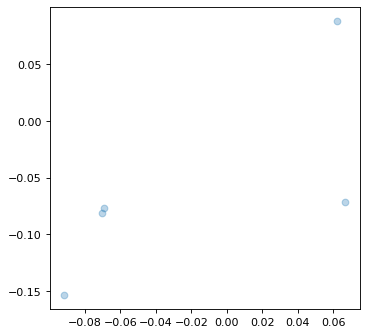

r2 = 0.509899
R2 = 0.246527
mse = 0.004746


In [91]:
# epistatic
figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean, y_test, 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean, y_test)[0]**2)
print('R2 = %f'%r2(y_test, f_mean))
print('mse = %f'%mse(f_mean, y_test))

In [37]:
model.train()

DiGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): MultiDeviceKernel(
    (module): DiKernel(
      (raw_lda_constraint): LessThan(0.000E+00)
      (raw_eta_constraint): LessThan(0.000E+00)
    )
  )
)

In [37]:
    N = train_x.size(0)

    # Find the optimum partition/checkpoint size by decreasing in powers of 2
    # Start with no partitioning (size = 0)
    settings = [0] + [int(n) for n in np.ceil(N / 2**np.arange(1, np.floor(np.log2(N))))]



In [38]:
settings

[0, 50000, 25000, 12500, 6250, 3125, 1563, 782, 391, 196, 98, 49, 25, 13, 7, 4]

In [38]:
import gc

def find_best_gpu_setting(train_x,
                          train_y,
                          n_devices,
                          output_device,
                          preconditioner_size
):
    N = train_x.size(0)

    # Find the optimum partition/checkpoint size by decreasing in powers of 2
    # Start with no partitioning (size = 0)
    settings = [0] + [int(n) for n in np.ceil(N / 2**np.arange(1, np.floor(np.log2(N))))]

    for checkpoint_size in settings:
        print('Number of devices: {} -- Kernel partition size: {}'.format(n_devices, checkpoint_size))
        try:
            # Try a full forward and backward pass with this setting to check memory usage
            

            with gpytorch.beta_features.checkpoint_kernel(checkpoint_size), \
                 gpytorch.settings.max_preconditioner_size(preconditioner_size):
                output = model(train_x)
                loss = -mll(output, train_y)
    
            

            # when successful, break out of for-loop and jump to finally block
            break
        except RuntimeError as e:
            print('RuntimeError: {}'.format(e))
        except AttributeError as e:
            print('AttributeError: {}'.format(e))
        finally:
            # handle CUDA OOM error
            gc.collect()
            torch.cuda.empty_cache()
    return checkpoint_size

# Set a large enough preconditioner size to reduce the number of CG iterations run
preconditioner_size = 100
checkpoint_size = find_best_gpu_setting(train_x, train_y,
                                        n_devices=n_devices,
                                        output_device=output_device,
                                        preconditioner_size=preconditioner_size)

Number of devices: 8 -- Kernel partition size: 0
RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/juannanzhou/.local/lib/python3.8/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/kernels/kernel.py", line 398, in __call__
    res = lazify(super(Kernel, self).__call__(x1_, x2_, last_dim_is_batch=last_dim_is_batch, **params))
  File "/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/module.py", line 30, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/scratch/local/29645306/ipykernel_211166/934878869.py", line 60, in forward
    diff = d(x1, x2)
  File "/scratch/local/29645306/ipykernel_211166/3148871899.py", line 17, in d
    return torch.stack((S1, S2, D1, D2))
RuntimeError: CUDA out of memory. Tried to allocate 37.25 GiB (GPU 0; 79.35 GiB total capacity; 51.4

In [39]:
checkpoint_size

4

In [35]:
settings = [0] + [int(n) for n in np.ceil(N / 2**np.arange(1, np.floor(np.log2(N))))]

In [37]:
settings

[0,
 95025,
 47513,
 23757,
 11879,
 5940,
 2970,
 1485,
 743,
 372,
 186,
 93,
 47,
 24,
 12,
 6,
 3]